In [5]:
import pandas as pd
import sys
import os
from pathlib import Path
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from mlforecast import MLForecast
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae
sys.path.append(str(Path("..").resolve()))
from src.data.feature_engineering import date_features, lags, partial
from src.data.data_preprocessing import prepare_df
from utilsforecast.feature_engineering import pipeline, fourier
from functools import partial

## 1️⃣ Data preparation

In [4]:
# -------------------------------
# 1.1 Data Prepartion for Nixtla
# -------------------------------


raw_path =r'C:\Users\Guest\Desktop\ds-projects\Energy-Forecasting\data\raw\PJME_hourly.csv'


df= pd.read_csv(raw_path)  # raw CSV  
df = prepare_df(df)                      # clean, rename, add unique_id
df.head()

,ds,y,unique_id
8734,2002-01-01 01:00:00,30393.0,A
8735,2002-01-01 02:00:00,29265.0,A
8736,2002-01-01 03:00:00,28357.0,A
8737,2002-01-01 04:00:00,27899.0,A
8738,2002-01-01 05:00:00,28057.0,A


## Feature Engineering 

In [ ]:
# -------------------------------
# 2. Apply exogenous features
# -------------------------------
# exg_features() returns list of feature functions (Fourier, etc.)




def exg_features():
    # Returns a list of partial functions for MLForecast
    return [partial(fourier, season_length=24, k=2)]


exg_df, future_df = pipeline(df, freq='h', h=50, features=exg_features())
print(f'Exogenous df shape: {exg_df.shape}')
exg_df.head()


Exogenous df shape: (145366, 7)


,ds,y,unique_id,sin1_24,sin2_24,cos1_24,cos2_24
8734,2002-01-01 01:00:00,30393.0,A,0.258819,0.500000,0.965926,8.660254e-01
8735,2002-01-01 02:00:00,29265.0,A,0.500000,0.866025,0.866025,5.000000e-01
8736,2002-01-01 03:00:00,28357.0,A,0.707107,1.000000,0.707107,-4.371139e-08
8737,2002-01-01 04:00:00,27899.0,A,0.866025,0.866025,0.500000,-5.000001e-01
8738,2002-01-01 05:00:00,28057.0,A,0.965926,0.500000,0.258819,-8.660254e-01


In [14]:
exg_df.tail()

,ds,y,unique_id,sin1_24,sin2_24,cos1_24,cos2_24
140250,2018-08-02 20:00:00,44057.0,A,-1.000000,-0.001969,0.000984,-0.999998
140251,2018-08-02 21:00:00,43256.0,A,-0.965692,-0.501565,0.259692,-0.865120
140252,2018-08-02 22:00:00,41552.0,A,-0.865614,-0.866847,0.500713,-0.498573
140253,2018-08-02 23:00:00,38500.0,A,-0.706582,-0.999999,0.707632,0.001485
140254,2018-08-03 00:00:00,35486.0,A,-0.499427,-0.865363,0.866356,0.501146


In [15]:
future_df.head()

,unique_id,ds,sin1_24,sin2_24,cos1_24,cos2_24
0,A,2018-08-03 01:00:00,-0.258258,-0.498993,0.966076,0.866606
1,A,2018-08-03 02:00:00,0.000501,0.001001,1.000000,1.000000
2,A,2018-08-03 03:00:00,0.259225,0.500727,0.965817,0.865605
3,A,2018-08-03 04:00:00,0.500294,0.866365,0.865856,0.499412
4,A,2018-08-03 05:00:00,0.707290,1.000000,0.706924,-0.000517


## 2️⃣ Models Training

In [26]:
# ===============================
# 
# ===============================

models = {
                'lreg': LinearRegression(),
                'dt': DecisionTreeRegressor(),
                'xgb': xgb.XGBRegressor()
}


ml = MLForecast(
                freq='h',
                models=models,
                lags=[1, 24],
                date_features=['dayofweek', 'hour'],

)


In [27]:
print(f'.......Training models using cross validation...')
cv_df = ml.cross_validation(
                h=50,
                df=exg_df,
                n_windows=8,
                step_size=50,
                refit=True,
                static_features=[]
)
#print(f'cross validation results', cv_df.head())
print(f'✅ Models trained successfully!')
cv_df.head()

.......Training models using cross validation...
✅ Models trained successfully!


,unique_id,ds,cutoff,y,lreg,dt,xgb
0,A,2018-07-17 09:00:00,2018-07-17 08:00:00,40896.0,38964.631365,39041.0,39127.199219
1,A,2018-07-17 10:00:00,2018-07-17 08:00:00,43309.0,39928.375548,42312.0,40870.820312
2,A,2018-07-17 11:00:00,2018-07-17 08:00:00,45887.0,41164.822649,45183.0,42838.835938
3,A,2018-07-17 12:00:00,2018-07-17 08:00:00,48061.0,42572.397453,47671.0,44604.230469
4,A,2018-07-17 13:00:00,2018-07-17 08:00:00,49586.0,44091.692226,49533.0,46275.789062


## 4️⃣ Evaluation and plotting

In [28]:
from utilsforecast.evaluation import evaluate


# Calculate performance metrics
metrics = evaluate(cv_df.drop(columns=['cutoff']),
                    metrics=[mae],
                    models=['lreg', 'dt', 'xgb']
            )

metrics

,unique_id,metric,lreg,dt,xgb
0,A,mae,4762.284736,3442.7275,2956.49897


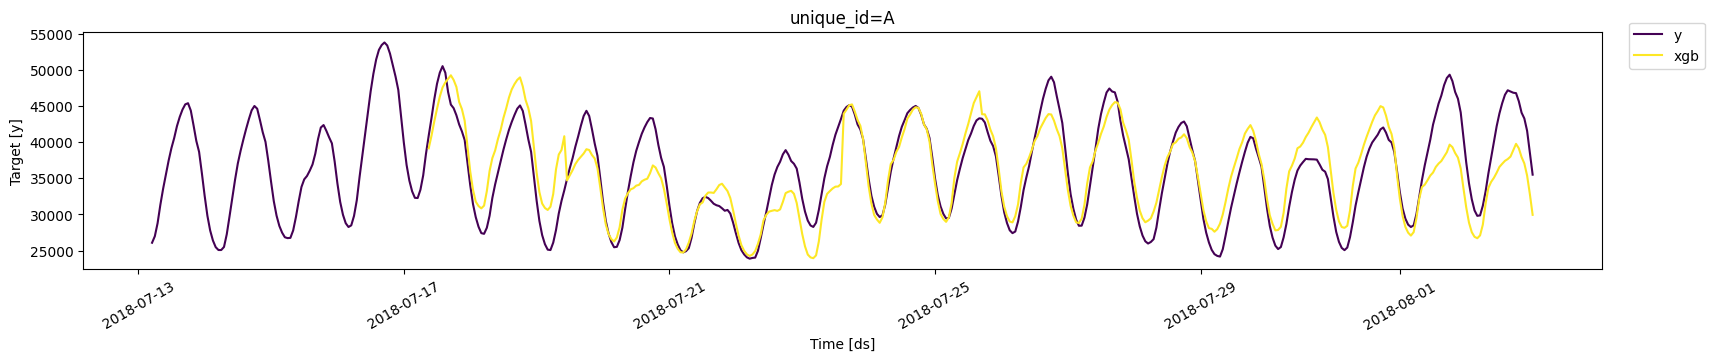

In [36]:
# 3.2 plotting

from utilsforecast.plotting import plot_series


plot_series(df=exg_df, 
                forecasts_df= cv_df.drop(columns=['cutoff', 'y']),
                max_insample_length=500,
                palette='viridis', 
                models=['xgb']
        )

In [43]:
import os
os.getcwd()

'c:\\Users\\Guest\\Desktop\\ds-projects\\Energy-Forecasting\\notbooks'